In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import warnings
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import spacy
from spacy import displacy
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('../data/cleaned_labeled_dataset_2.xlsx')
df.head()

,text,label,clean_text
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies tepuk tangan meriah rektor mewajibkan ma...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,"memang bener memang, pendukung 01 goblok, pend..."
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,anies bersikap kritis kinerja prabowo dianggap...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn tni polri pegang sump...


In [3]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

text          0
label         0
clean_text    0
dtype: int64

In [4]:
df.drop(columns='text', inplace=True)
df.head()

,label,clean_text
0,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...
1,Politik,anies tepuk tangan meriah rektor mewajibkan ma...
2,Demografi,"memang bener memang, pendukung 01 goblok, pend..."
3,Politik,anies bersikap kritis kinerja prabowo dianggap...
4,Politik,anies baswedan harap asn tni polri pegang sump...


In [5]:
def get_top_words(df, n=3, stop_words=None):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    words_freq = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi kata
        vectorizer = CountVectorizer(stop_words=stop_words)
        X = vectorizer.fit_transform(group['clean_text'])
        word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        total_freq = word_freq.sum().sort_values(ascending=False)
        
        # Simpan n kata yang paling sering muncul dan frekuensinya
        words_freq[name] = total_freq.nlargest(n).to_dict()

    # buat fitur dari kata-kata yang paling sering muncul
    features = set()
    for label, freq in words_freq.items():
        for word in freq.keys():
            features.add(word)

    features = list(features)

    return words_freq, features


# persentase kata yang paling sering muncul
def get_top_words_percentage(df, n=3, stop_words=None):
    words_freq, features = get_top_words(df, n, stop_words)

    grouped = df.groupby('label')

    words_percentage = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi kata
        vectorizer = CountVectorizer(stop_words=stop_words)
        X = vectorizer.fit_transform(group['clean_text'])
        word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        total_freq = word_freq.sum().sort_values(ascending=False)
        
        # Hitung persentase kata yang paling sering muncul
        words_percentage[name] = (total_freq.nlargest(n) / total_freq.sum() * 100).to_dict()

    return words_percentage


def tokenize(text, stopwords):
    # Cari semua hashtag dan hapus stopwords
    return [word for word in re.findall(r"#(\w+)", text) if word not in stopwords]

def get_top_hashtags(df, n=3, stopwords=None):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    hashtags_freq = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi hashtag
        vectorizer = CountVectorizer(tokenizer=lambda text: tokenize(text, stopwords))
        X = vectorizer.fit_transform(group['clean_text'])
        hashtag_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
        total_freq = hashtag_freq.sum().sort_values(ascending=False)
        
        # Simpan n hashtag yang paling sering muncul dan frekuensinya
        hashtags_freq[name] = total_freq.nlargest(n).to_dict()

    # buat fitur dari hashtag yang paling sering muncul
    features = set()
    for label, freq in hashtags_freq.items():
        for hashtag in freq.keys():
            features.add(hashtag)

    features = list(features)

    return hashtags_freq, features

# NER (Named Entity Recognition) menggunakan Spacy


nlp = spacy.load('en_core_web_sm')

def get_named_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

def get_top_named_entities(df, n=3):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    entities_freq = {}

    for name, group in grouped:
        # Tokenisasi dan hitung frekuensi named entities
        entities = group['clean_text'].apply(get_named_entities)
        entities = pd.Series([ent for sublist in entities for ent in sublist])
        total_freq = entities.value_counts()
        
        # Simpan n named entities yang paling sering muncul dan frekuensinya
        entities_freq[name] = total_freq.nlargest(n).to_dict()

    # buat fitur dari named entities yang paling sering muncul
    features = set()
    for label, freq in entities_freq.items():
        for entity in freq.keys():
            features.add(entity)

    features = list(features)

    return entities_freq, features


# sentimen analisis data bahasa indonesia menggunakan library Sastrawi dan TextBlob bahasa indonesia 


def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def get_top_sentiments(df):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    sentiments = {}

    for name, group in grouped:
        # Hitung sentimen
        sentiment = group['clean_text'].apply(get_sentiment)
        sentiments[name] = sentiment.mean()

    return sentiments

# todo
# topic modeling menggunakan LDA (Latent Dirichlet Allocation) untuk menemukan topik-topik yang ada dalam masing-masing label
from gensim import corpora, models
from sklearn.preprocessing import MultiLabelBinarizer

def get_lda_topics(df, num_topics=10):
    # Tokenisasi teks
    texts = df['clean_text'].apply(lambda x: x.split())

    # Buat dictionary dan corpus yang diperlukan untuk LDA
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Buat model LDA
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Dapatkan topik-topik dari model LDA
    topics = lda_model.print_topics(num_words=5)

    # Dapatkan distribusi topik untuk setiap dokumen
    topic_distribution = [lda_model.get_document_topics(bow) for bow in corpus]

    # Ubah distribusi topik menjadi list of lists
    topic_lists = [[dict(td).get(i, 0) for i in range(num_topics)] for td in topic_distribution]

    # Ubah list of lists menjadi array 2D
    topic_features = np.array(topic_lists)

    return topic_features, topics
 
# word embedding menggunakan Word2Vec dari library Gensim untuk dijadikan kolom fitur dalam dataframe
from gensim.models import Word2Vec

def get_word_embeddings(df, vector_size=100, window=5, min_count=1, workers=4):
    # Tokenisasi teks
    texts = df['clean_text'].apply(lambda x: x.split())

    # Buat model Word2Vec
    model = Word2Vec(texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers)

    # Dapatkan vektor kata untuk setiap kata yang ada di model
    word_vectors = model.wv

    # Dapatkan vektor rata-rata untuk setiap dokumen
    doc_vectors = texts.apply(lambda x: np.mean([word_vectors[word] for word in x if word in word_vectors], axis=0))

    # Ubah vektor dokumen menjadi array 2D
    doc_features = np.array(doc_vectors.tolist())

    return doc_features

# character-level features

def get_character_features(df):
    # Jumlah karakter
    df['char_count'] = df['clean_text'].apply(len)

    # Jumlah kata
    df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

    # Rata-rata panjang kata
    df['avg_word_length'] = df['char_count'] / df['word_count']

    # Std dev panjang kata
    df['std_word_length'] = df['clean_text'].apply(lambda x: np.std([len(word) for word in x.split()]))

    return df

# sentiment score menggunakan VADER dari library NLTK
from textblob import TextBlob

def get_sentiment_scores(df):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    sentiments = {}

    for name, group in grouped:
        # Hitung sentimen
        sentiment = group['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        sentiments[name] = sentiment.mean()

    return sentiments

# readability score menggunakan Flesch-Kincaid Grade Level
from textstat import flesch_kincaid_grade

def get_readability_score(text):
    return flesch_kincaid_grade(text)

def get_readability_scores(df):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    readabilities = {}

    for name, group in grouped:
        # Hitung readability score
        readability = group['clean_text'].apply(get_readability_score)
        readabilities[name] = readability.mean()

    return readabilities

# syntatic features menggunakan library SpaCy

def get_syntactic_features(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    dep_tags = [token.dep_ for token in doc]
    return pos_tags, dep_tags

def get_syntactic_features_df(df):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    pos_tags = {}
    dep_tags = {}

    for name, group in grouped:
        # Hitung POS tags dan dependency tags
        pos_tags[name], dep_tags[name] = zip(*group['clean_text'].apply(get_syntactic_features))

    return pos_tags, dep_tags

# semantic features menggunakan library SpaCy

def get_semantic_features(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

def get_semantic_features_df(df):
    # Pisahkan data berdasarkan label
    grouped = df.groupby('label')

    entities = {}

    for name, group in grouped:
        # Hitung named entities
        entities[name] = group['clean_text'].apply(get_semantic_features)

    return entities

# POS tagging menggunakan library SpaCy

# def get_pos_tags(text):
#     doc = nlp(text)
#     pos_tags = [token.pos_ for token in doc]
#     return pos_tags

# def get_pos_tags_df(df):
#     # Pisahkan data berdasarkan label
#     grouped = df.groupby('label')

#     pos_tags = {}

#     for name, group in grouped:
#         # Hitung POS tags
#         pos_tags[name] = group['clean_text'].apply(get_pos_tags)

#     return pos_tags

# dependency parsing menggunakan library SpaCy

# def get_dep_tags(text):
#     doc = nlp(text)
#     dep_tags = [token.dep_ for token in doc]
#     return dep_tags

# def get_dep_tags_df(df):
#     # Pisahkan data berdasarkan label
#     grouped = df.groupby('label')

#     dep_tags = {}

#     for name, group in grouped:
#         # Hitung dependency tags
#         dep_tags[name] = group['clean_text'].apply(get_dep_tags)

#     return dep_tags

# words_percentage = get_top_words_percentage(df, n=40)

# # masukkan menjadi fitur ke dalam dataframe
# for label, freq in words_percentage.items():
#     for word, percentage in freq.items():
#         df[f'{label}_{word}'] = df['clean_text'].str.contains(word).astype(int)

# sentiments = get_top_sentiments(df)

# # masukkan menjadi fitur ke dalam dataframe
# for label, sentiment in sentiments.items():
#     df[f'{label}_sentiment'] = sentiment

# topic_features, topics = get_lda_topics(df, num_topics=3)

# # masukkan menjadi fitur ke dalam dataframe
# for i, topic in enumerate(topics):
#     for j, (word, _) in enumerate(topic):
#         df[f'topic_{i+1}_{j+1}'] = df['clean_text'].str.contains(word).astype(int)

# word_embeddings = get_word_embeddings(df, size=100)






In [6]:
get_character_features(df)

,label,clean_text,char_count,word_count,avg_word_length,std_word_length
0,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...,162,15,10.800000,4.924316
1,Politik,anies tepuk tangan meriah rektor mewajibkan ma...,121,14,8.642857,4.526566
2,Demografi,"memang bener memang, pendukung 01 goblok, pend...",154,20,7.700000,2.342541
3,Politik,anies bersikap kritis kinerja prabowo dianggap...,157,22,7.136364,1.968764
4,Politik,anies baswedan harap asn tni polri pegang sump...,64,10,6.400000,1.802776
...,...,...,...,...,...,...
4986,Politik,"ngeliat debat kemaren prabowo kicep, kekira ke...",84,13,6.461538,2.170267
4987,Politik,masyarakat prabowo-gibran memiliki visi sejala...,108,10,10.800000,4.548626
4988,Ekonomi,imo both are irrational but irrational tbh. bu...,159,24,6.625000,2.733537
4989,Pertahanan dan Keamanan,"look at that ganjar, berkecimpung lgislatif, e...",167,22,7.590909,2.532434


In [7]:
# sentiment_scores = get_sentiment_scores(df)

# # masukkan menjadi fitur ke dalam dataframe
# for label, score in sentiment_scores.items():
#     df[f'{label}_sentiment_score'] = score


In [8]:
# readability_scores = get_readability_scores(df)

# # masukkan menjadi fitur ke dalam dataframe
# for label, score in readability_scores.items():
#     df[f'{label}_readability_score'] = score


In [9]:
# pos_tags, dep_tags = get_syntactic_features_df(df)

In [10]:
# # encode pos tags menjadi one-hot encoding
# mlb = MultiLabelBinarizer()

# pos_tags = {label: mlb.fit_transform(tag) for label, tag in pos_tags.items()}
# dep_tags = {label: mlb.fit_transform(tag) for label, tag in dep_tags.items()}

In [11]:
# # cari postags yang paling sering muncul
# pos_tags_freq = {}
# for label, tags in pos_tags.items():
#     total_freq = tags.sum(axis=0)
#     pos_tags_freq[label] = total_freq.argsort()[::-1][:3]

# pos_tags_freq

# # output 
# '''
# {'Demografi': array([11, 12,  7], dtype=int64),
#  'Ekonomi': array([10, 11,  7], dtype=int64),
#  'Geografi': array([8, 7, 4], dtype=int64),
#  'Ideologi': array([11,  7, 12], dtype=int64),
#  'Pertahanan dan Keamanan': array([11, 12,  7], dtype=int64),
#  'Politik': array([11, 12,  7], dtype=int64),
#  'Sosial Budaya': array([11, 12,  7], dtype=int64),
#  'Sumber Daya Alam': array([11, 12,  7], dtype=int64)}
# '''

# pos_tags_freq_dict = {
#     'Demografi': [11, 12, 7],
#     'Ekonomi': [10, 11, 7],
#     'Geografi': [8, 7, 4],
#     'Ideologi': [11, 7, 12],
#     'Pertahanan dan Keamanan': [11, 12, 7],
#     'Politik': [11, 12, 7],
#     'Sosial Budaya': [11, 12, 7],
#     'Sumber Daya Alam': [11, 12, 7]
# }

# # masukkan dictionary pos_tags_freq_dict ke dalam dataframe sesuai dengan labelnya.
# for label, freq in pos_tags_freq_dict.items():
#     for i, tag in enumerate(freq):
#         df[f'{label}_pos_tag_{i+1}'] = tag
#         # df[f'{label}_pos_tag_{i+1}'] = [pos_tags[label][:, tag]] * len(df)

    


In [12]:
# dep_tags_freq = {}
# for label, tags in dep_tags.items():
#     total_freq = tags.sum(axis=0)
#     dep_tags_freq[label] = total_freq.argsort()[::-1][:3]

# '''
# {'Demografi': array([ 0, 11, 25], dtype=int64),
#  'Ekonomi': array([ 0, 12, 30], dtype=int64),
#  'Geografi': array([18,  6,  0], dtype=int64),
#  'Ideologi': array([ 0, 13, 37], dtype=int64),
#  'Pertahanan dan Keamanan': array([ 0, 12, 36], dtype=int64),
#  'Politik': array([ 0, 14, 40], dtype=int64),
#  'Sosial Budaya': array([ 0, 13, 36], dtype=int64),
#  'Sumber Daya Alam': array([ 0, 11, 27], dtype=int64)}
# '''

# dep_tags_freq_dict = {
#     'Demografi': [0, 11, 25],
#     'Ekonomi': [0, 12, 30],
#     'Geografi': [18, 6, 0],
#     'Ideologi': [0, 13, 37],
#     'Pertahanan dan Keamanan': [0, 12, 36],
#     'Politik': [0, 14, 40],
#     'Sosial Budaya': [0, 13, 36],
#     'Sumber Daya Alam': [0, 11, 27]
# }

# # masukkan dictionary dep_tags_freq_dict ke dalam dataframe sesuai dengan labelnya.
# for label, freq in dep_tags_freq_dict.items():
#     for i, tag in enumerate(freq):
#         df[f'{label}_dep_tag_{i+1}'] = tag
#         # df[f'{label}_dep_tag_{i+1}'] = [dep_tags[label][:, tag]] * len(df)

# df.head()


In [13]:
# entities = get_semantic_features_df(df)
# entities

In [14]:
# # cari named entities yang paling sering muncul
# entities_freq = {}

# for label, ents in entities.items():
#     entities_freq[label] = pd.Series([ent for sublist in ents for ent in sublist]).value_counts().to_dict()

# entities_freq

In [15]:
df.columns

Index(['label', 'clean_text', 'char_count', 'word_count', 'avg_word_length',
       'std_word_length'],
      dtype='object')

In [16]:
word_embeddings = get_word_embeddings(df, vector_size=100)
word_embeddings = pd.DataFrame(word_embeddings, columns=[f'word_embedding_{i+1}' for i in range(100)])

df = pd.concat([df, word_embeddings], axis=1)

In [17]:
topic_features, topics = get_lda_topics(df, num_topics=40)
topic_features, topics

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.14351887, ..., 0.        , 0.14282356,
         0.07081331],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 [(27,
   '0.099*"anies" + 0.046*"jakarta" + 0.031*"baswedan" + 0.019*"rekam" + 0.018*"gubernur"'),
  (10,
   '0.021*"a" + 0.012*"is" + 0.012*"prabowo," + 0.012*"presiden," + 0.011*"this"'),
  (9,
   '0.118*"ganjar" + 0.057*"#ganjarmahfud2024" + 0.053*"mahfud" + 0.037*"#coblos3" + 0.029*"hebat"'),
  (1,
   '0.036*"02" + 0.035*"serangan" + 0.031*"akun" + 0.030*"kubu" + 0.029*"prabowo"'),
  (12,
   '0.063*"s

In [18]:
# Ubah fitur topik menjadi dataframe
topic_df = pd.DataFrame(topic_features, columns=[f'topic_{i}' for i in range(topic_features.shape[1])])
topic_df


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.500534,0.0,0.0,0.0,0.364915,0.0,0.00000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.806584,0.0,0.00000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,0.163706,0.0,0.000000,0.000000,0.000000,0.105294,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.114778,0.0,0.00000,0.000000,0.000000
4987,0.000000,0.0,0.000000,0.610784,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.13993,0.000000,0.000000
4988,0.000000,0.0,0.143519,0.000000,0.000000,0.000000,0.154335,0.0,0.0,0.069067,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.142824,0.070813
4989,0.000000,0.0,0.000000,0.000000,0.168796,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000


In [19]:
# Gabungkan fitur topik dengan dataframe asli
df = pd.concat([df, topic_df], axis=1)

In [20]:
# entities_freq, entities_features = get_top_named_entities(df, n=3)


# print(entities_freq)
# print(entities_features)

In [21]:
words_percentage = get_top_words_percentage(df, n=40)

# masukkan menjadi fitur ke dalam dataframe
# for label, freq in words_percentage.items():
#     for word, percentage in freq.items():
#         df[f'{label}_{word}'] = df['clean_text'].str.contains(word).astype(int)

# sentiments = get_top_sentiments(df) # n tidak digunakan

# # masukkan menjadi fitur ke dalam dataframe
# for label, sentiment in sentiments.items():
#     df[f'{label}_sentiment'] = sentiment


In [22]:
# words_freq, features_kata = get_top_words(df, n=10, stop_words=['ganjar', 'anies', 'prabowo',
#                                                            'mahfud', 'pranowo', 'dalam',
#                                                              'ganjarpranowopilihanumat', 'ganjarmahfudrebound', 'ganjarmahfud2024',
#                                                              'indonesia', 'capres', 'gibran', 'md',
#                                                              'cawapres', 'presiden', 'jnk',
                                                             
#                                                              ])
# print(words_freq)
# print(features_kata)

In [23]:
words_freq, features_kata = get_top_words(df, n=40, stop_words=[
                                                             ])
# kalau pakai n 50 dia meningkat dari 75 ke 78
print(words_freq)
print(features_kata)

{'Demografi': {'anies': 43, 'ganjar': 39, 'prabowo': 21, 'mahfud': 20, 'anak': 17, 'muda': 16, 'kalangan': 14, 'etnis': 13, 'generasi': 12, 'gibran': 11, 'indonesia': 11, 'kalbar': 10, 'pendidikan': 9, 'jawa': 9, 'program': 8, 'keluarga': 8, 'menengah': 8, 'tokoh': 8, 'mas': 7, '02': 7, 'masyarakat': 7, 'adat': 7, 'banget': 7, 'gratis': 7, 'barat': 7, 'ganjarmahfud2024': 7, 'lain': 7, 'petani': 7, 'pranowo': 6, 'prajurit': 6, 'presiden': 6, 'desak': 6, '2024': 6, 'dalam': 6, 'mendukung': 6, 'rakyat': 5, 'rabu': 5, 'batak': 5, 'bhayangkara': 5, 'kota': 5}, 'Ekonomi': {'ganjar': 267, 'ekonomi': 170, 'pranowo': 166, 'mahfud': 158, 'jnk': 141, 'ganjarpranowopilihanumat': 140, 'md': 129, 'ganjarmahfudrebound': 124, 'capres': 122, 'prabowo': 112, 'program': 104, 'petani': 88, 'anies': 85, 'cawapres': 83, 'pasangan': 73, 'indonesia': 69, 'dalam': 65, 'nelayan': 59, 'pupuk': 53, 'pertanian': 51, 'gibran': 51, 'desa': 46, 'lahan': 45, 'mendukung': 45, 'prof': 44, 'food': 43, 'nomor': 43, 'estat

In [24]:
df['clean_text'].iloc[0]

'kunjungan prabowo meresmikan menyerahkan proyek bantuan air bersih titik. #indonesiasentris #indonesiahijau #02melanjutkan #anakmudaindonesiaemas prabowo subianto'

In [25]:
stopwords = []
hashtags_freq, features_hastag = get_top_hashtags(df, n=5, stopwords=stopwords)
print(hashtags_freq)
print(features_hastag)

{'Demografi': {'ganjarmahfud2024': 7, 'l3bihbaik': 3, '02melanjutkan': 2, 'indonesiahijau': 2, 'anakmudaindonesiaemas': 2}, 'Ekonomi': {'jnk': 141, 'ganjarpranowopilihanumat': 140, 'ganjarmahfudrebound': 124, 'ganjarmahfud2024': 27, 'rembuganjar': 19}, 'Geografi': {'ganjarmahfud2024': 1, 'hotlineparisamin': 1, 'l3bihbaik': 1, 'mahfudlebihbaik3': 1}, 'Ideologi': {'ganjarpranowopilihanumat': 143, 'jnk': 112, 'ganjarmahfudrebound': 101, 'ganjar': 25, 'ganjarmahfud2024': 25}, 'Pertahanan dan Keamanan': {'ganjarmahfud2024': 74, 'coblos3': 33, 'dulujokowisekarangganjar': 23, 'l3bihbaik': 20, 'debatcapres': 14}, 'Politik': {'jnk': 470, 'ganjarmahfudrebound': 449, 'ganjarpranowopilihanumat': 422, 'ganjarmahfud2024': 213, 'coblos3': 161}, 'Sosial Budaya': {'aminajadulu': 55, 'ganjarmahfud2024': 29, 'rembuganjar': 17, 'ganjarmahfudrebound': 14, 'jnk': 14}, 'Sumber Daya Alam': {'indonesiasentris': 29, 'indonesiahijau': 24, '02melanjutkan': 24, 'anakmudaindonesiaemas': 24, 'jnk': 11}}
['anakmudain

In [26]:
# tambahkan fitur ke dataframe dan isi dengan frekuensi hashtag
for feature in features_hastag:
    df[feature] = 0

for i, row in df.iterrows():
    for feature in features_hastag:
        df.at[i, feature] = row['clean_text'].count('#' + feature)
        

In [27]:
# tambahkan fitur ke dataframe dan isi dengan frekuensi kata
for feature in features_kata:
    df[feature] = 0

for i, row in df.iterrows():
    for feature in features_kata:
        df.at[i, feature] = row['clean_text'].count(feature)

df.head()

,label,clean_text,char_count,word_count,avg_word_length,std_word_length,word_embedding_1,word_embedding_2,word_embedding_3,word_embedding_4,...,kampanye,semarang,presiden,pupuk,hukum,adat,banget,batak,pasangan,jawa
0,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...,162,15,10.800000,4.924316,-0.164138,0.659929,0.132113,0.026933,...,0,0,0,0,0,0,0,0,0,0
1,Politik,anies tepuk tangan meriah rektor mewajibkan ma...,121,14,8.642857,4.526566,-0.131027,0.282191,0.106748,0.023929,...,0,0,0,0,0,0,0,0,0,0
2,Demografi,"memang bener memang, pendukung 01 goblok, pend...",154,20,7.700000,2.342541,-0.154037,0.347994,0.112822,0.026035,...,0,0,0,0,0,0,0,0,0,0
3,Politik,anies bersikap kritis kinerja prabowo dianggap...,157,22,7.136364,1.968764,-0.202086,0.495162,0.163135,0.035509,...,0,0,0,0,0,0,0,0,0,0
4,Politik,anies baswedan harap asn tni polri pegang sump...,64,10,6.400000,1.802776,-0.370769,0.770254,0.297478,0.041770,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# total kolom df
print(df.columns)
print(len(df.columns))

Index(['label', 'clean_text', 'char_count', 'word_count', 'avg_word_length',
       'std_word_length', 'word_embedding_1', 'word_embedding_2',
       'word_embedding_3', 'word_embedding_4',
       ...
       'kampanye', 'semarang', 'presiden', 'pupuk', 'hukum', 'adat', 'banget',
       'batak', 'pasangan', 'jawa'],
      dtype='object', length=338)
338


In [29]:
# simpan ke file
# df.to_excel('../data/feature_extracted_dataset.xlsx', index=False)

In [30]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

X = df.drop(columns=['label', 'clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)


0.4232184964442084

In [32]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

# Instantiate the LabelEncoder
le = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# xgboost
clf = XGBClassifier(random_state=42)
clf.fit(X_train, y_train_encoded)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test_encoded, y_pred)

0.46609957607614416

In [33]:
# seimbangkan
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

clf = XGBClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test_encoded, y_pred)


0.46020542133105213

In [34]:
# seimbangkan
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test_encoded, y_pred)

0.4549119634871257

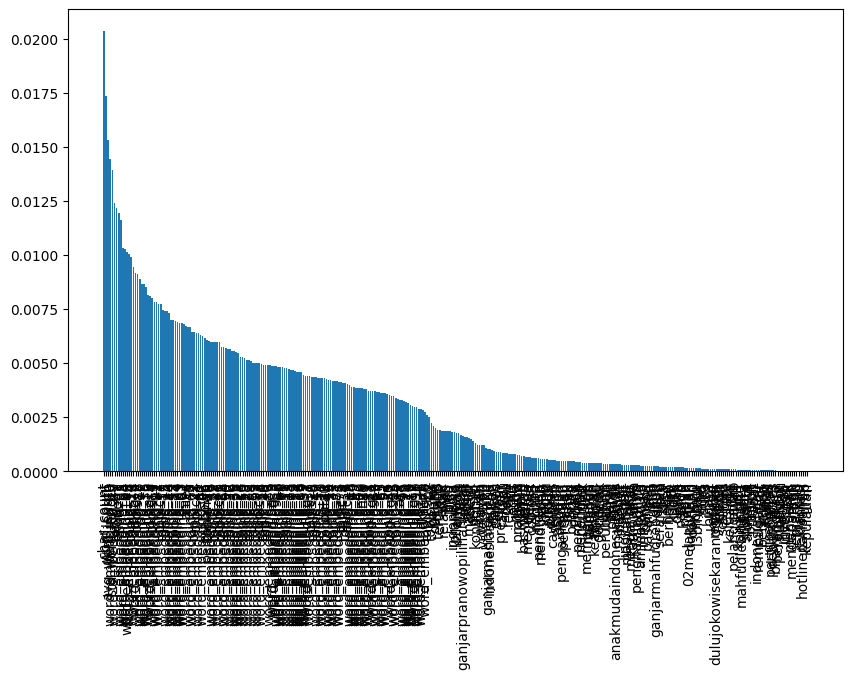

In [35]:
# feature importance
import matplotlib.pyplot as plt

importances = clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()


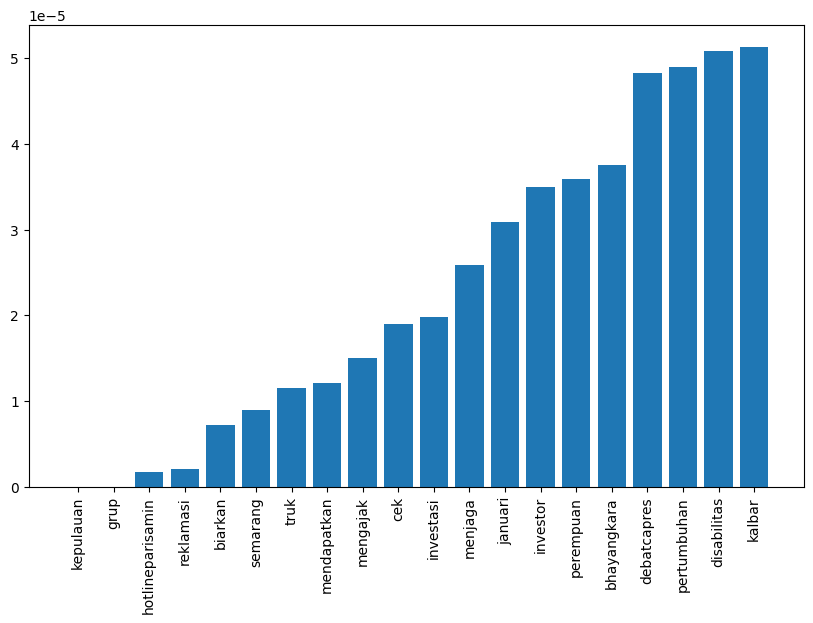

In [36]:
# 20 fitur terbawah
importances = clf.feature_importances_
indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.show()


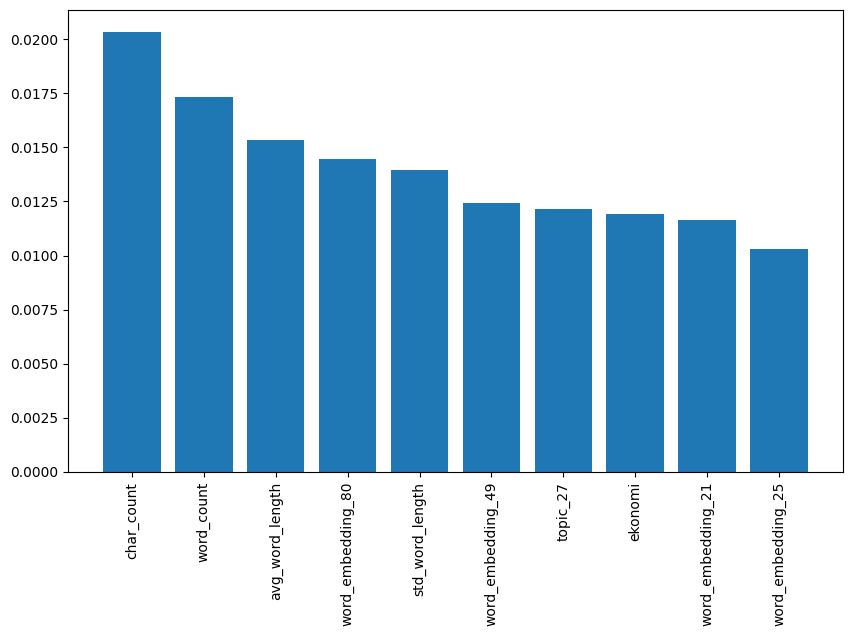

In [37]:
# 10 fitur teratas
importances = clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), X.columns[indices][:10], rotation=90)
plt.show()